Nombre de colonnes dans le jeu de données avant suppression : 86
Nombre de lignes dans le jeu de données avant suppression : 3033961
Nombre de colonnes dans le jeu de données après suppression : 86
Nombre de lignes dans le jeu de données après suppression : 2230398
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4         

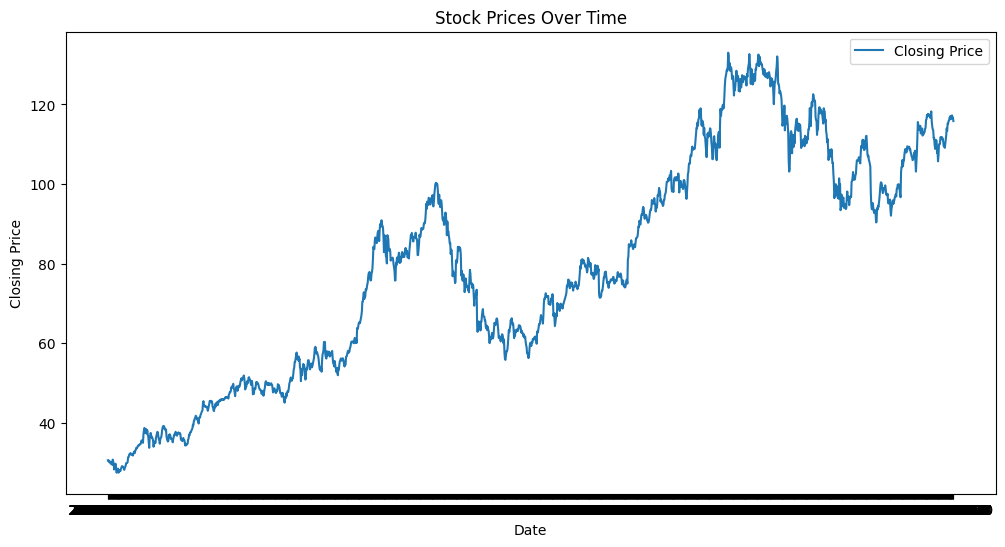

Époque 1/10, Perte (entraînement) : 3551.106862325408, Perte (validation) : 197.7670301089841
Époque 2/10, Perte (entraînement) : 17.88060867663151, Perte (validation) : 0.8889759067975124
Époque 3/10, Perte (entraînement) : 0.8607056094022197, Perte (validation) : 0.8884553288252572
Époque 4/10, Perte (entraînement) : 0.8577017334848375, Perte (validation) : 0.8873760570476695
Époque 5/10, Perte (entraînement) : 0.8550826324423885, Perte (validation) : 0.8795333846676641
Époque 6/10, Perte (entraînement) : 0.8526131165601377, Perte (validation) : 0.8762101736737461
Époque 7/10, Perte (entraînement) : 0.8488770382926456, Perte (validation) : 0.8738557169783107
Époque 8/10, Perte (entraînement) : 0.8462229597805151, Perte (validation) : 0.875636226973006
Époque 9/10, Perte (entraînement) : 0.8438552539935937, Perte (validation) : 0.8707488921891839
Époque 10/10, Perte (entraînement) : 0.8408305426429519, Perte (validation) : 0.8648303647144795
Perte finale après 10 époques (entraînement

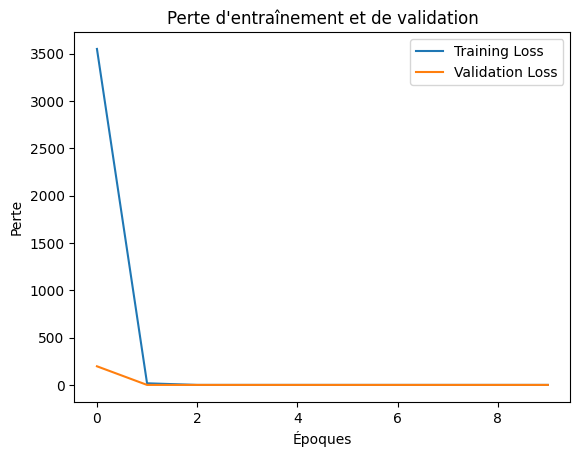

Predicted: 9648.945


In [24]:
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Charger les données
fundamentals = pd.read_csv('/kaggle/input/nyse/fundamentals.csv')
prices = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv')

# Fusionner les données
merged_data = pd.merge(fundamentals, prices, left_on="Ticker Symbol", right_on="symbol", how="inner")

# Afficher le nombre de colonnes et de lignes avant la suppression
print(f"Nombre de colonnes dans le jeu de données avant suppression : {merged_data.shape[1]}")
print(f"Nombre de lignes dans le jeu de données avant suppression : {merged_data.shape[0]}")

# Supprimer les lignes avec des valeurs manquantes
merged_data = merged_data.dropna()

# Supprimer les lignes dupliquées
merged_data = merged_data.drop_duplicates()

# Afficher le nombre de colonnes et de lignes après la suppression
print(f"Nombre de colonnes dans le jeu de données après suppression : {merged_data.shape[1]}")
print(f"Nombre de lignes dans le jeu de données après suppression : {merged_data.shape[0]}")

# Sélectionner les fonctionnalités pertinentes
selected_features = ["high", "low", "open", "Earnings Per Share"]
target_variable = "close"
data = merged_data[selected_features + [target_variable]]



# Affichez les premières lignes des datasets
print(fundamentals.head())
print(prices.head())


# Vérifiez les informations sur les colonnes et les types de données
print(fundamentals.info())
print(prices.info())


# Statistiques descriptives
print(fundamentals.describe())
print(prices.describe())


# Visualisation des prix pour une entreprise donnée
company_prices = prices[prices['symbol'] == 'AAPL']
plt.figure(figsize=(12, 6))
plt.plot(company_prices['date'], company_prices['close'], label='Closing Price')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data[selected_features], data[target_variable], test_size=0.2, random_state=42)

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir les données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Créer un DataLoader pour l'entraînement
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Créer un ensemble de validation
X_val, X_test, y_val, y_test = train_test_split(X_test_tensor, y_test_tensor, test_size=0.5, random_state=42)

# Créer un DataLoader pour la validation
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Définir le modèle de régression
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc(x)

# Initialiser le modèle
input_size = len(selected_features)
model = RegressionModel(input_size)

# Définir la fonction de perte et l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
num_epochs = 10
train_losses = []
val_losses = []  # Nouvelle liste pour stocker les pertes de validation

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_dataloader))

    # Modele en mode d'évaluation pour la validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_losses.append(val_loss / len(val_dataloader))

    # Afficher la perte par époque pendant l'entraînement et la validation
    print(f"Époque {epoch + 1}/{num_epochs}, Perte (entraînement) : {epoch_loss / len(train_dataloader)}, Perte (validation) : {val_loss / len(val_dataloader)}")

# Afficher la perte finale après l'entraînement
print(f"Perte finale après {num_epochs} époques (entraînement) : {train_losses[-1]}")
print(f"Perte finale après {num_epochs} époques (validation) : {val_losses[-1]}")

# Visualiser la perte par époque pour l'entraînement et la validation
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement et de validation')
plt.legend()
plt.show()
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat
row = [126, 122, 123 , 8.35]
yhat = predict(row, model)
print('Predicted: %.3f' % yhat)